In [5]:
import glob 
import os
import pandas as pd
import json

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
paths = glob.glob('results_hyper/flights-*run*.txt')

In [35]:
# return the per thread times basically...
def extract_s3_fast_path_time_agg(data):
    agg_times = None
    for task in data['tasks']:
        lines = task['log']
        lines = lines[lines.find('calling initStageFunctor'):lines.rfind('fast path took')]
        lines = lines.split('\n')
        lines = list(filter(lambda line: 's3 request time spent' in line, lines))
        
        times = list(map(lambda L: float(L[L.find(': ')+2:-1]), lines))
        times = np.array(times).sum()
        if agg_times is None:
            agg_times = times
        else:
            agg_times += times
    return agg_times


# sampling (setInputFiles) took 0.711429s
def extract_s3_sample_agg(data):
    try:
        agg_times = None
        for task in data['tasks']:
            lines = task['log']
            lines = lines[lines.find('calling initStageFunctor'):lines.rfind('fast path took')]
            lines = lines.split('\n')
            lines = list(filter(lambda line: 'sampling (setInputFiles) took ' in line, lines))

            times = list(map(lambda L: float(L[L.find('took ')+5:L.rfind('s ')]), lines))
            times = np.array(times).sum()
            if agg_times is None:
                agg_times = times
            else:
                agg_times += times
        return agg_times
    except:
        return None


def extract_row(path):
    with open(path) as fp:
        lines = fp.readlines()

        sel = list(filter(lambda line: line.startswith('{"startupTime":'), lines))
        row = json.loads(sel[0])
        name = os.path.basename(path).replace('flights-', '')
        xq = name.split('-')
        run = xq[-1]
        
        mode = name.replace('flights-', '').replace('-run-', '').replace(run, '')
        
        run = int(run.replace('.txt', ''))
        row['mode'] = mode
        row['run'] = run
        row['path'] = path

        sel = list(filter(lambda line: 'LAMBDA compute took' in line, lines))[0]
        lam_compute = float(sel[sel.find('took ')+5:sel.rfind('s,')])
        row['lambdaComputeTime'] = lam_compute
        cost = float(sel[sel.find('cost $')+6:].strip())

        row['cost'] = cost
        
        
        # json part:
        json_path = 'results_hyper/flights-{}/job_{:04d}.json'.format(mode, run - 1)
        with open(json_path, 'r') as fp:
            data = json.load(fp)

            in_normal = data['input_paths_taken']['normal']
            in_general = data['input_paths_taken']['general']
            in_fallback = data['input_paths_taken']['fallback']
            in_unresolved = data['input_paths_taken']['unresolved']

            out_normal = data['output_paths_taken']['normal']
            out_unresolved = data['output_paths_taken']['unresolved']

            requests = data['requests']

            timings = dict(zip(['t_fast', 't_slow', 't_hyper', 't_compile', 't_fast_per_row'],
                            [0, 0, 0, 0, 0]))
            num_reqs_with_normal = 0
            for req in requests:
                for k in ['t_fast', 't_slow', 't_hyper', 't_compile']:
                    timings[k] += req.get(k, None)
                r_in_normal = req['input_paths_taken']['normal']
                if 0 != r_in_normal:
                    timings['t_fast_per_row'] += req['t_fast'] / r_in_normal
                    num_reqs_with_normal += 1

            row['in_normal'] = in_normal
            row['in_general'] = in_general
            row['in_fallback'] = in_fallback
            row['in_unresolved'] = in_unresolved
            row['out_normal'] = out_normal
            row['out_unresolved'] = out_unresolved

            row['cost'] = data['cost']
            
            # total lambda compute cost (across all lambdas)
            
            row['s3_fast_path'] = extract_s3_fast_path_time_agg(data).sum()
            row['s3_hyper_sample'] = extract_s3_sample_agg(data).sum()
            timings['t_fast_per_row'] /= num_reqs_with_normal
            row.update(timings)
        

        return row


In [26]:
rows = []
for path in paths:
    rows.append(extract_row(path))
    
df = pd.DataFrame(rows)

In [27]:
# get rid off first run (warmup)
df = df[df['run'] != 1]
# df = df[df['run'] != 3]

In [28]:
df[['mode', 'startupTime', 'jobTime', 'lambdaComputeTime', 'cost']].sort_values(by='jobTime').groupby('mode').agg(['mean', 'std']).reset_index()

mode startupTime              jobTime           lambdaComputeTime  \
                       mean       std       mean       std              mean   
0         hyper    0.231292  0.047789  20.994687  2.072049         17.181867   
1    hyper-nocf    0.223909  0.014264  18.109115  1.191720         14.241800   
2       nohyper    0.212696  0.013563  17.553841  1.643886         13.068133   
3  nohyper-nocf    0.221549  0.019993  17.478943  1.589475         13.088083   

                 cost            
        std      mean       std  
0  2.084759  0.537768  0.000866  
1  1.169150  0.526839  0.001200  
2  1.559094  0.467531  0.001223  
3  1.564028  0.467859  0.000488

In [32]:
df['s3_hyper_sample']

0     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
Name: s3_hyper_sample, dtype: float64

Text(0, 0.5, 'end-to-end time in s')

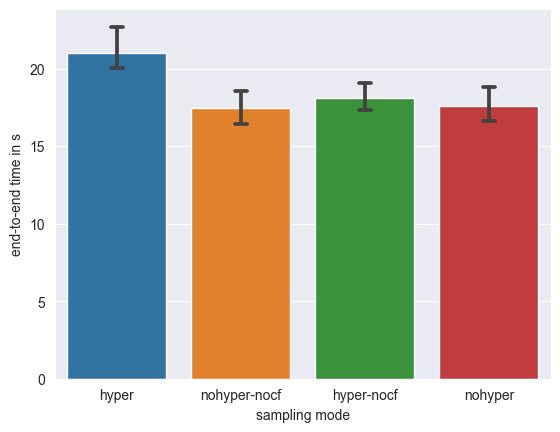

In [29]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='jobTime', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('end-to-end time in s')

Text(0, 0.5, '#normal rows')

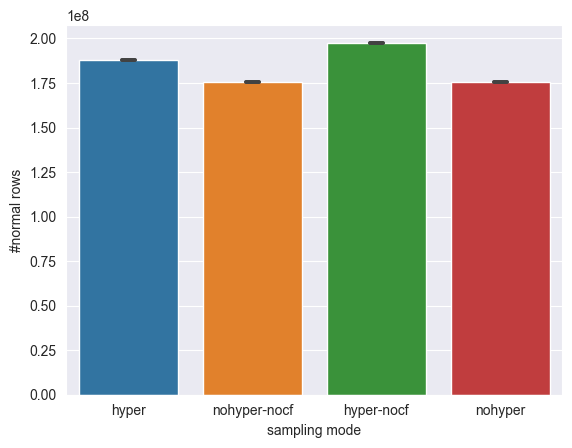

In [30]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='in_normal', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('#normal rows')

Text(0, 0.5, '#general rows')

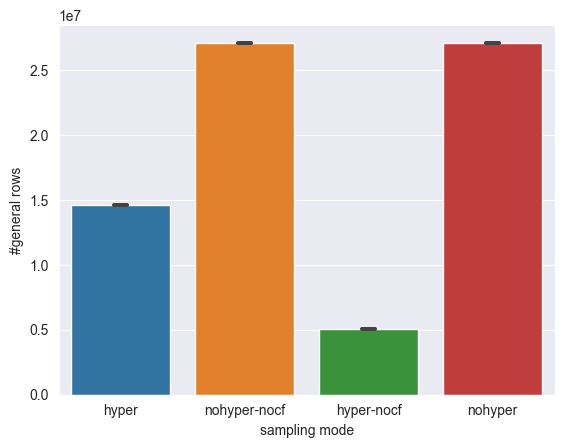

In [13]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='in_general', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('#general rows')

Text(0, 0.5, '#fallback rows')

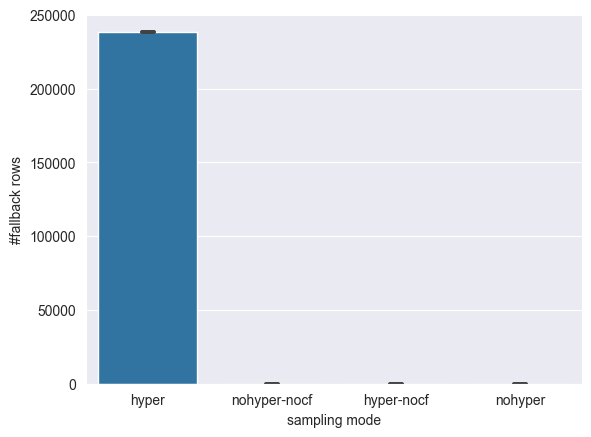

In [14]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='in_fallback', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('#fallback rows')

Text(0, 0.5, 'time in fast path')

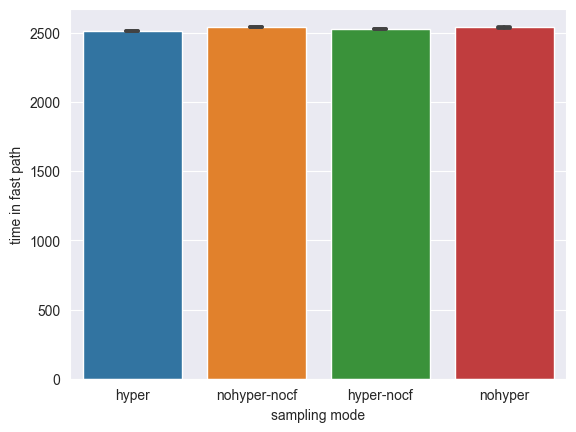

In [15]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='t_fast', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time in fast path')
# plt.ylim(1300, 1420)

(1500.0, 1600.0)

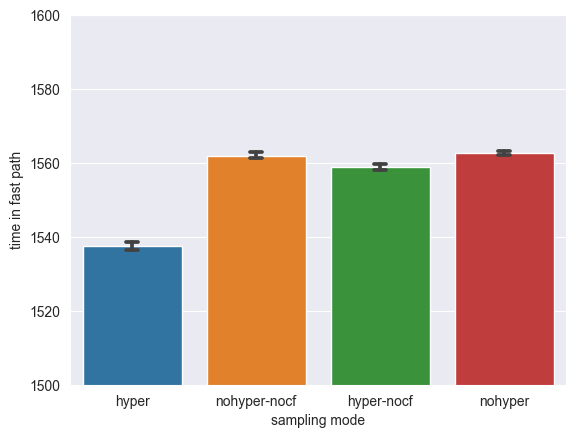

In [16]:
df['t_fast_without_s3'] = df['t_fast'] - df['s3_fast_path']

sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='t_fast_without_s3', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time in fast path')
plt.ylim(1500, 1600)

Text(0, 0.5, 'time in slow (general + interpreter) path')

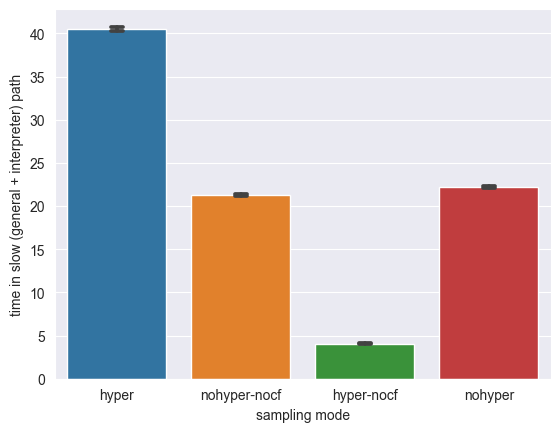

In [17]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='t_slow', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time in slow (general + interpreter) path')

Text(0, 0.5, 'time spend compiling')

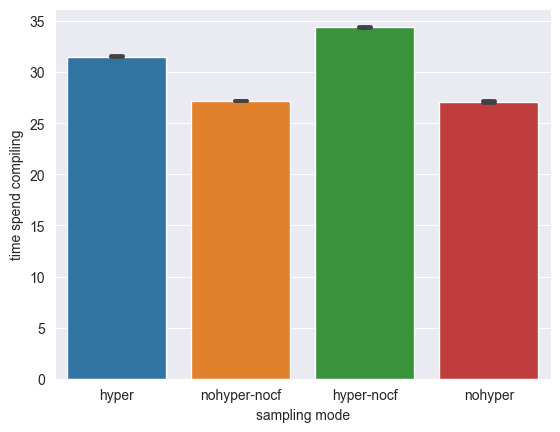

In [18]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='t_compile', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time spend compiling')

Text(0, 0.5, 'time spend hyperspecializing')

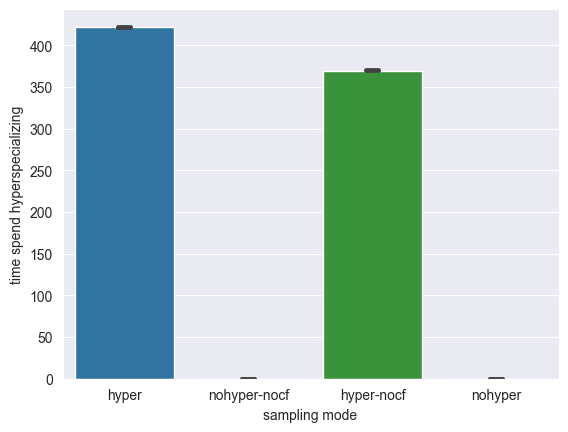

In [19]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='t_hyper', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time spend hyperspecializing')

Text(0, 0.5, 'cost per query in $ (USD)')

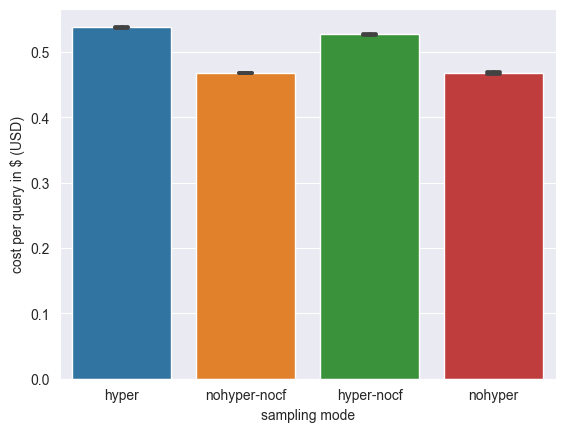

In [20]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='cost', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('cost per query in $ (USD)')

(0.0, 0.6)

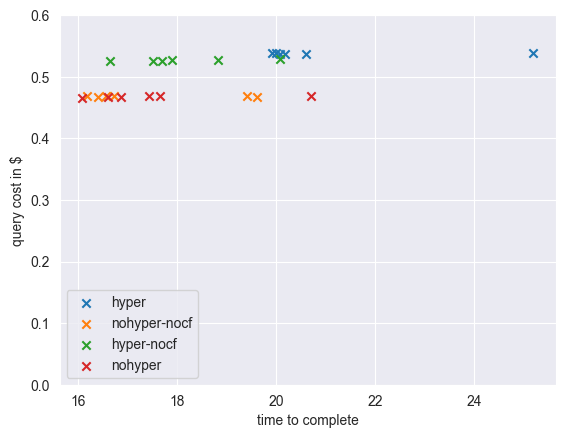

In [22]:
import itertools
marker = itertools.cycle(('x', 'v', '^', ',', '+', '>', 'o', '<')) 
marker = itertools.cycle(('x')) 
for i, mode in enumerate(df['mode'].unique()):
    plt.scatter(df[df['mode'] == mode]['jobTime'], 
                df[df['mode'] == mode]['cost'], label=mode, 
               marker=next(marker))
plt.legend()
#plt.ylim(0, 0.6)
#plt.xlim(0, 60)
plt.xlabel('time to complete')
plt.ylabel('query cost in $')
plt.ylim(0, 0.6)

In [24]:
# --> CSV limit sample rows.
# 50 rows from start/end.
# sampling?

# applies to both.
# increase buffers, avoid spilling?

In [143]:
# what about the compute times?

In [144]:
for mode in df['mode'].unique():
    json_root_path = f'results_hyper/flights-{mode}'
    print(json_root_path)
    
    paths = glob.glob(json_root_path + '/*.json')
    for path in paths:
        name = os.path.basename(path)
        xq = name.split('_')
        run = xq[-1]
        run = int(run.replace('.json', ''))
        print(run)

results_hyper/flights-hyper
6
1
0
3
2
5
4
results_hyper/flights-nohyper-nocf
6
1
0
3
2
5
4
results_hyper/flights-hyper-nocf
6
1
0
3
2
5
4
results_hyper/flights-nohyper
6
1
0
3
2
5
4


In [145]:
paths

['results_hyper/flights-nohyper/job_0006.json',
 'results_hyper/flights-nohyper/job_0001.json',
 'results_hyper/flights-nohyper/job_0000.json',
 'results_hyper/flights-nohyper/job_0003.json',
 'results_hyper/flights-nohyper/job_0002.json',
 'results_hyper/flights-nohyper/job_0005.json',
 'results_hyper/flights-nohyper/job_0004.json']

In [146]:
!ls results_hyper

flights-hyper                         flights-nohyper
flights-hyper-nocf                    flights-nohyper-nocf
flights-hyper-nocf-run-1.json         flights-nohyper-nocf-run-1.json
flights-hyper-nocf-run-1.txt          flights-nohyper-nocf-run-1.txt
flights-hyper-nocf-run-1.txt.stderr   flights-nohyper-nocf-run-1.txt.stderr
flights-hyper-nocf-run-2.json         flights-nohyper-nocf-run-2.json
flights-hyper-nocf-run-2.txt          flights-nohyper-nocf-run-2.txt
flights-hyper-nocf-run-2.txt.stderr   flights-nohyper-nocf-run-2.txt.stderr
flights-hyper-nocf-run-3.json         flights-nohyper-nocf-run-3.json
flights-hyper-nocf-run-3.txt          flights-nohyper-nocf-run-3.txt
flights-hyper-nocf-run-3.txt.stderr   flights-nohyper-nocf-run-3.txt.stderr
flights-hyper-nocf-run-4.json         flights-nohyper-nocf-run-4.json
flights-hyper-nocf-run-4.txt          flights-nohyper-nocf-run-4.txt
flights-hyper-nocf-run-4.txt.stderr   flights-nohyper-nocf-run-4.txt.stderr
flights-hyper-nocf-run-5.js

In [227]:
json_path = 'results_hyper/flights-hyper/job_0005.json'
with open(json_path, 'r') as fp:
    data = json.load(fp)

In [229]:
df_reqs = pd.DataFrame(data['requests'])

In [233]:
df_reqs['general'] = df_reqs['input_paths_taken'].apply(lambda d: d['general'])
df_reqs['normal'] = df_reqs['input_paths_taken'].apply(lambda d: d['normal'])
df_reqs['fallback'] = df_reqs['input_paths_taken'].apply(lambda d: d['fallback'])
df_reqs['total'] = df_reqs['general'] + df_reqs['normal'] + df_reqs['fallback']

In [235]:
df_reqs['general_pct'] = df_reqs['general'] / df_reqs['total'] * 100

In [236]:
df_reqs.sort_values(by='general_pct', ascending=False).head()

,requestId,containerId,durationInMs,billedDurationInMs,memorySizeInMb,maxMemoryUsedInMb,returnCode,errorMessage,input_paths_taken,output_paths_taken,...,t_compile,t_fast,t_slow,tsRequestStart,tsRequestEnd,general,normal,fallback,total,general_pct
408,6c2ffef6-f067-4f97-8265-49c594b2a6e3,222df63d-11f0-4d13-ab9d-fb371c8e6d93,12658.70,12659,10000,694,0,,"{'normal': 3416, 'general': 561372, 'fallback'...","{'normal': 564788, 'unresolved': 0}",...,0.083547,8.47295,2.593580,1670304575301827105,1670304588097745777,561372,3416,0,564788,99.395171
33,057b3c40-63f2-4a31-b17d-628c5379a82c,e1bcc187-54ea-495a-a392-5b2e1e5dfdc0,6794.22,6795,10000,649,0,,"{'normal': 6384, 'general': 399220, 'fallback'...","{'normal': 405604, 'unresolved': 0}",...,0.085656,4.91520,0.339883,1670304572417826103,1670304579516020492,399220,6384,0,405604,98.426051
406,c1c3e4d6-a5e6-436b-a3af-6f879d20cbca,c9c32416-0861-4f24-955a-a93d79bd140e,12645.90,12646,10000,731,0,,"{'normal': 9513, 'general': 586533, 'fallback'...","{'normal': 596046, 'unresolved': 0}",...,0.078482,8.51183,2.615010,1670304574991974294,1670304587798468814,586533,9513,0,596046,98.403982
407,f117eb5e-6424-4ff0-9bb4-320d6dd3d0dc,55d81b1e-46ba-4c4b-a9cf-368f14df9b4b,13532.00,13533,10000,744,0,,"{'normal': 23925, 'general': 629354, 'fallback...","{'normal': 653279, 'unresolved': 0}",...,0.078147,9.30498,2.667130,1670304574317295075,1670304587983507892,629354,23925,0,653279,96.337706
67,315862ea-01ef-4ce4-912a-fa75bc600197,4b1f32e7-b758-4dbd-99e0-094952964c6f,6968.50,6969,10000,659,0,,"{'normal': 20015, 'general': 410101, 'fallback...","{'normal': 430116, 'unresolved': 0}",...,0.075892,5.03578,0.358851,1670304572706283411,1670304579873891031,410101,20015,0,430116,95.346604


In [241]:
bad_req_example = list(filter(lambda x: x['container']['requestId'] == '6c2ffef6-f067-4f97-8265-49c594b2a6e3', data['tasks']))[0]

In [244]:
print(bad_req_example['log'])

[2022-12-06 05:29:08.432] [Lambda worker] [info] performing global initialization (Worker App)
[2022-12-06 05:29:08.437] [Lambda worker] [info] Invoking WorkerApp fallback
[2022-12-06 05:29:08.439] [Lambda worker] [info] Found 1 input URIs to process
[2022-12-06 05:29:08.439] [Lambda worker] [info] *** hyperspecialization active ***
[2022-12-06 05:29:08.439] [Lambda worker] [info] -- specializing to s3://tuplex-public/data/flights_all/flights_on_time_performance_2021_10.csv:0-255035341
[2022-12-06 05:29:08.439] [hyper specializer] [info] specializing code to file s3://tuplex-public/data/flights_all/flights_on_time_performance_2021_10.csv:0-255035341
[2022-12-06 05:29:08.440] [hyper specializer] [info] Decompressed Code context from 9.40 KB to 88.30 KB
[2022-12-06 05:29:08.479] [hyper specializer] [info] Deserialization of Code context took 0.039445s
[2022-12-06 05:29:08.479] [hyper specializer] [info] Total Stage Decode took 0.040183s
[2022-12-06 05:29:08.479] [hyper specializer] [info

In [34]:
410 * 0.71

291.09999999999997